In [1]:
import numpy as np
import xarray as xr
import rioxarray as rxr
from xrspatial import zonal_stats
from osgeo import gdal
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import mask
import rasterio
from rioxarray import open_rasterio
from shapely.geometry import mapping
import pandas as pd
import fiona

# 1. Visualize data

In [2]:
# params
num_k = 100
colname = f'ecoregion{num_k}'
cat_path = f'/mnt/poseidon/remotesensing/arctic/data/Hoffman_LandscapeEcology_2013/ecoregions/alaska_2000_2009_dem_Feb2012.{num_k}.nc'
shp_path = '/mnt/poseidon/remotesensing/arctic/data/vectors/supplementary/tundra_alaska_polygon_latlon/tundra_alaska_wgs84.shp'
cavm_cat_path = '/mnt/poseidon/remotesensing/arctic/data/rasters/cavm/raster_cavm_v1.tif'

In [3]:
# load study area
study_area = gpd.read_file(shp_path)
ecoregions = open_rasterio(cat_path, masked=True).squeeze()
cavm = open_rasterio(cavm_cat_path, masked=True).squeeze()

In [4]:
# match projections -- reprojecting cat data doesn't work right
# so I reproject the poly to match cat data
print('-- tile poly crs: ', study_area.crs)
print('-- raster crs: ', ecoregions.rio.crs)
print('-- cavm raster crs: ', cavm.rio.crs, '\n')

# reproject
cavm_study_area = study_area.to_crs(cavm.rio.crs, inplace=True)
eco_study_area = study_area.to_crs(ecoregions.rio.crs, inplace=True)
print('-- new tile poly crs: ', study_area.crs)
print('-- new raster crs: ', ecoregions.rio.crs)
print('-- new cavm raster crs: ', cavm.rio.crs)

-- tile poly crs:  EPSG:4326
-- raster crs:  PROJCS["Albers Equal Area",GEOGCS["grs80",DATUM["North_American_Datum_1983",SPHEROID["Geodetic_Reference_System_1980",6378137,298.257222101],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",55],PARAMETER["standard_parallel_2",65],PARAMETER["latitude_of_center",50],PARAMETER["longitude_of_center",-154],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
-- cavm raster crs:  PROJCS["Sphere_ARC_INFO_Lambert_Azimuthal_Equal_Area",GEOGCS["GCS_Sphere_ARC_INFO",DATUM["Sphere_ARC_INFO",SPHEROID["Sphere_ARC_INFO",6370997,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",90],PARAMETER["longitude_of_center",-180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT

Text(0.5, 1.0, 'alaska_2000_2009_dem_Feb2012.100.nc')

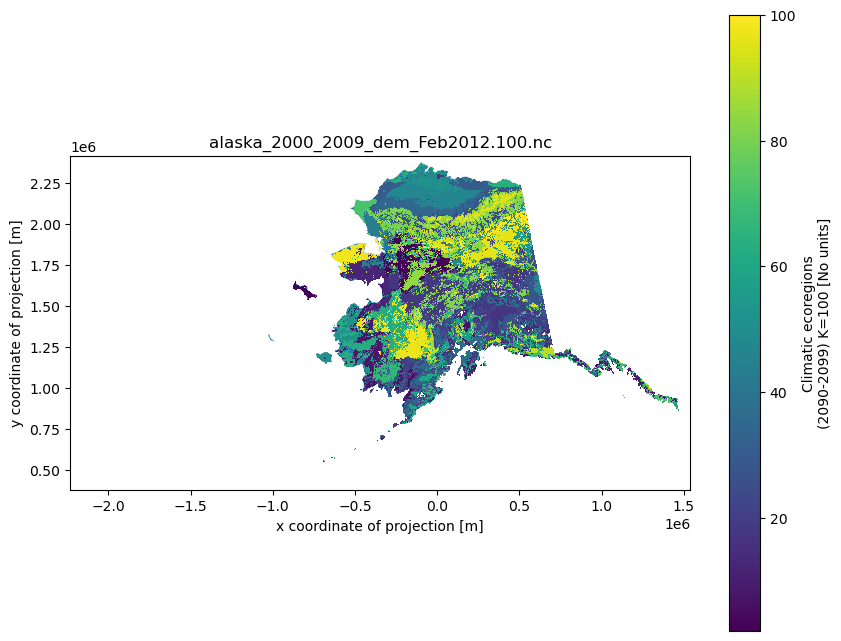

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
study_area.plot(ax=ax)
ecoregions.plot(ax=ax)
plt.title(cat_path.split('/')[-1])

In [6]:
cavm = rxr.open_rasterio(cavm_cat_path,
                         masked=True).squeeze()
crop_extent = gpd.read_file(shp_path)
clipped = cavm.rio.clip(crop_extent.geometry.apply(mapping),
                        crop_extent.crs)

In [7]:
cavm_labs = [
 [1, 'B1', 'cryptogram herb barren'],
 [2, 'B2a', 'cryptogram barren complex'],
 [3, 'B3', 'noncarbonate mtn complex'],
 [4, 'B4', 'carbonate mtn complex'],
 [5, 'B2b', 'cryptogram, barren, dwarf-shrub complex'],
 [21, 'G1', 'rush, grass, forb, cryptogram tundra'],
 [22, 'G2', 'graminoid, prostrate dwarf shrub, forb tundra'],
 [23, 'G3', 'nontussock sedge, dwarf shrub, moss tundra'],
 [24, 'G4', 'tussock sedge, dwarf shrub, moss tundra'],
 [31, 'P1', 'prostrate dwarf shrub, herb tundra'],
 [32, 'P2', 'hemi-/prostrate dwarf tundra'],
 [33, 'S1', 'erect dwarf tundra'],
 [34, 'S2', 'low shrub tundra'],
 [41, 'W1', 'sedge, grass, moss wetland'],
 [42, 'W2', 'sedge, moss, dwarf shrub wetland'],
 [43, 'W3', 'sedge, moss, low shrub wetland'],
 [91, 'other', 'fresh water'],
 [92, 'other', 'saline water'],
 [93, 'other', 'glacier'],
 [99, 'other', 'non-arctic']]
drop_labs = ['other']

In [8]:
nums = []
names = []
abbrs = []
for lab in cavm_labs:
    nums.append(lab[0])
    abbrs.append(lab[1])
    names.append(lab[2])

In [9]:
ds = clipped.to_dataset(name='cavm')

In [10]:
ds = ds.assign(nums=nums)
ds = ds.assign(abbrs=abbrs)
ds = ds.assign(names=names)

In [11]:
ds_r = ds.rio.reproject(ecoregions.rio.crs)

In [12]:
cmap = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

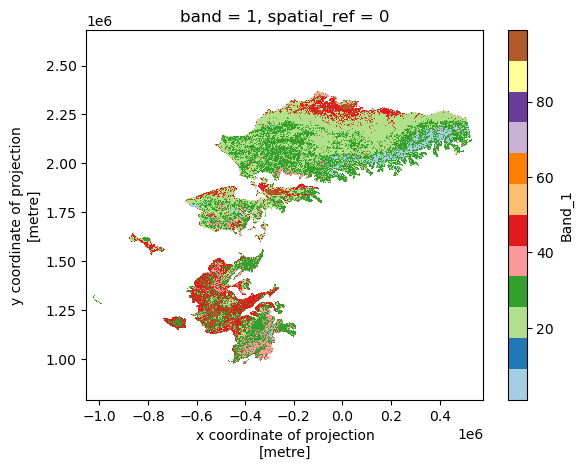

In [13]:
ds_r.cavm.plot(cmap='Paired')

# Stats for CAVM

In [14]:
opt = '_mac' # '' or '_mac'
path = '/mnt/poseidon/remotesensing/arctic/data/training/Test_06/zonalstats_watermask'
dshrub = f'{path}/deciduous_shrub_zs_masked_clipped{opt}.csv'
eshrub = f'{path}/evergreen_shrub_zs_masked_clipped{opt}.csv'
forb = f'{path}/forb_zs_masked_clipped{opt}.csv'
gram = f'{path}/graminoid_zs_masked_clipped{opt}.csv'
litter = f'{path}/litter_zs_masked_clipped{opt}.csv'
lichen = f'{path}/lichen_zs_masked_clipped{opt}.csv'
bryo = f'{path}/bryophyte_zs_masked_clipped{opt}.csv'
nonvasc = f'{path}/non-vascular_zs_masked_clipped{opt}.csv'

pft_paths = [dshrub, eshrub, forb, gram, litter,  nonvasc, lichen, bryo]
pft_labs = ['deciduous shrub', 'evergreen shrub', 'forb', 'graminoid', 'litter', 'non-vascular', 'lichen', 'bryophyte']

In [15]:
pft_dfs = []
for path in pft_paths:
    print(path)
    pft_df = pd.read_csv(path)
    z = pft_df.iloc[:, :1]
    d = pft_df.iloc[:, 2:]
    df = pd.concat([z,d], axis=1)
    df = df.iloc[1:, :]
    pft_dfs.append(df)

/mnt/poseidon/remotesensing/arctic/data/training/Test_06/zonalstats_watermask/deciduous_shrub_zs_masked_clipped_mac.csv
/mnt/poseidon/remotesensing/arctic/data/training/Test_06/zonalstats_watermask/evergreen_shrub_zs_masked_clipped_mac.csv
/mnt/poseidon/remotesensing/arctic/data/training/Test_06/zonalstats_watermask/forb_zs_masked_clipped_mac.csv
/mnt/poseidon/remotesensing/arctic/data/training/Test_06/zonalstats_watermask/graminoid_zs_masked_clipped_mac.csv
/mnt/poseidon/remotesensing/arctic/data/training/Test_06/zonalstats_watermask/litter_zs_masked_clipped_mac.csv
/mnt/poseidon/remotesensing/arctic/data/training/Test_06/zonalstats_watermask/non-vascular_zs_masked_clipped_mac.csv
/mnt/poseidon/remotesensing/arctic/data/training/Test_06/zonalstats_watermask/lichen_zs_masked_clipped_mac.csv
/mnt/poseidon/remotesensing/arctic/data/training/Test_06/zonalstats_watermask/bryophyte_zs_masked_clipped_mac.csv


In [16]:
pft_dfs[0]

,zone,non_null_cells,null_cells,min,max,range,mean,mean_of_abs,stddev,variance,coeff_var,sum,sum_abs,first_quart,median,third_quart,perc_90
1,1,1613027,2065439,0.0,52.0,52.0,5.977481,5.977481,4.290257,18.406304,71.773654,9.641839e+06,9.641839e+06,3.0,6.0,9.0,11.0
2,2,0,2168511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,4959510,62208915,0.0,70.0,70.0,13.523420,13.523420,4.224346,17.845097,31.237258,6.706954e+07,6.706954e+07,11.0,13.0,15.0,19.0
4,4,569729,33747982,1.0,54.0,53.0,14.577873,14.577873,3.857556,14.880737,26.461719,8.305437e+06,8.305437e+06,12.0,14.0,17.0,20.0
5,23,134261434,192281599,0.0,101.0,101.0,13.680999,13.680999,8.443300,71.289322,61.715524,1.836831e+09,1.836831e+09,8.0,13.0,17.0,24.0
6,24,379458794,353878612,0.0,102.0,102.0,24.476291,24.476291,11.110472,123.442597,45.392794,9.287744e+09,9.287744e+09,18.0,23.0,30.0,37.0
7,31,8107721,231586292,0.0,97.0,97.0,17.114442,17.114442,7.005422,49.075943,40.932813,1.387591e+08,1.387591e+08,13.0,15.0,20.0,25.0
8,33,152610124,473524158,0.0,102.0,102.0,29.519256,29.519256,10.565656,111.633097,35.792421,4.504937e+09,4.504937e+09,23.0,28.0,33.0,41.0
9,34,1765479,67538546,3.0,99.0,96.0,30.833413,30.833413,11.864127,140.757520,38.478151,5.443574e+07,5.443574e+07,23.0,28.0,34.0,46.0
10,41,3181498,4476415,0.0,56.0,56.0,6.739875,6.739875,4.089743,16.725995,60.679802,2.144290e+07,2.144290e+07,4.0,6.0,9.0,12.0


In [17]:
def share_axes(axes, xlab, sharex=True, sharey=False):
    if isinstance(axes, np.ndarray):
        axes = axes.flat  # from plt.subplots
    elif isinstance(axes, dict):
        axes = list(axes.values())  # from plt.subplot_mosaic
    else:
        axes = list(axes)
    ax0 = axes[0]
    for ax in axes:
        if sharex:
            ax.sharex(ax0)
            if not ax.get_subplotspec().is_last_row():
                ax.tick_params(labelbottom=False)
                continue
            ax.set_xlabel(xlab, fontsize=14)
        if sharey:
            ax.sharey(ax0)
            if not ax.get_subplotspec().is_first_col():
                ax.tick_params(labelleft=False)

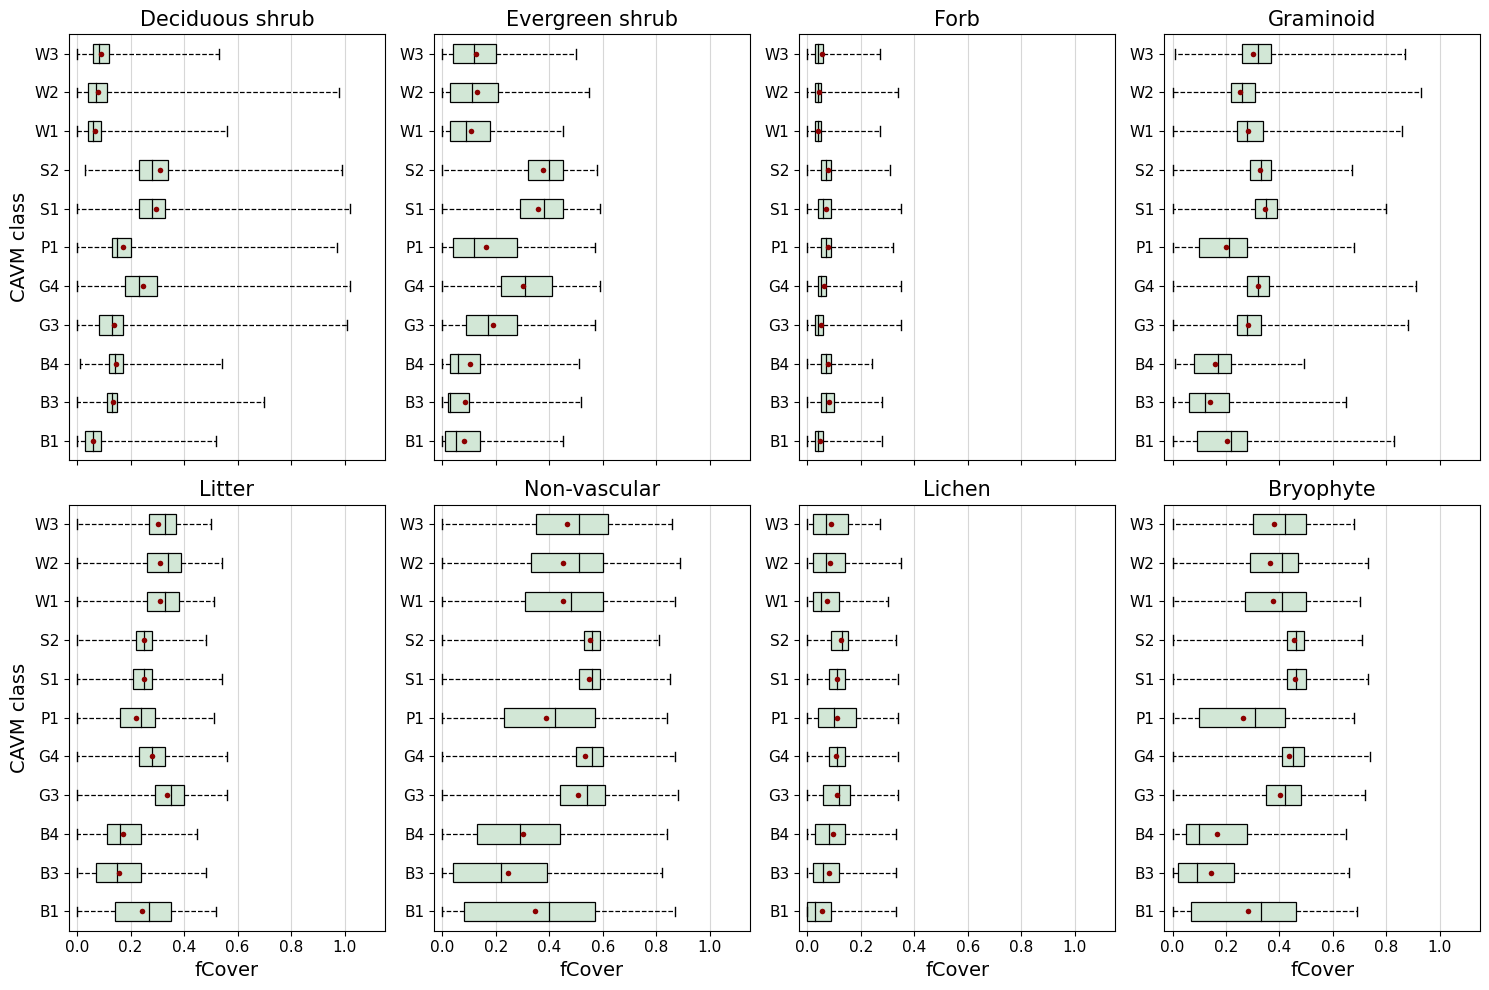

In [21]:
pft_stats = []
pft_ylabs = []
for pft_df, pft in zip(pft_dfs, pft_labs):
    
    stats = []
    ylabs = []
    pft_df = pft_df.dropna(how='any')
    for index, row in pft_df.iterrows():

        # set vars (divide by 100 for macander)
        med = row['median'] / 100
        q1 = row['first_quart'] / 100
        q3 = row['third_quart'] / 100
        whislo = row['min'] / 100
        whishi = row['max'] / 100
        zone = row['zone']
        mean = row['mean'] / 100

        # create boxplot dictionary
        if opt == '_macander_':
            zone_dict = {'med': med/100, 'q1': q1/100, 'q3': q3/100, 
                         'whislo': whislo/100, 'whishi': whishi/100, 
                         'mean': mean/100}
        else:
            zone_dict = {'med': med, 'q1': q1, 'q3': q3, 
                         'whislo': whislo, 'whishi': whishi, 
                         'mean': mean}    

        # get title label
        for classif in cavm_labs:
            if zone in classif:
                zone_lab = classif[1]
        
        if zone_lab in drop_labs:
            continue
            
        ylabs.append(zone_lab)
        stats.append(zone_dict)
    pft_stats.append(stats)
    pft_ylabs.append(ylabs)
            
# plot   
fig, axs = plt.subplots(2, 4, figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

# loop through the length of tickers and keep track of index
ax_list = axs.flatten()
for ax, ylabs, stats, lab in zip(ax_list, pft_ylabs, pft_stats, pft_labs):

    # filter df and plot ticker on the new subplot axis
    bplot = ax.bxp(stats, showfliers=False, showmeans=True, vert=False, patch_artist=True,
               whiskerprops=dict(linestyle='--', linewidth=.9, color='black'),
               boxprops=dict(linewidth=.9, facecolor='#d2e7d6'),
               medianprops=dict(linewidth=.9, color='black'),
               meanprops=dict(marker='.', markersize=8, markerfacecolor='#8B0000', markeredgewidth=0.0))
    
    colors = ['#d2e7d6']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    # chart formatting
    ax.set_title(lab.capitalize(), fontsize=15)
    ax.set_xlim([-0.03, 1.15])
    ax.grid(visible=True, which='major', axis='x', alpha=.5)
    ax.set_yticklabels(ylabs, fontdict=dict(fontsize=11))
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(11)

# cleanup
locs, labels = plt.yticks()
ax_list[0].set_ylabel('CAVM class', fontsize=14)
ax_list[4].set_ylabel('CAVM class', fontsize=14)
share_axes(ax_list, 'fCover')
plt.tight_layout()
plt.show()

In [103]:
for pft_df, pft_lab in zip(pft_dfs, pft_labs):
    pft_df['pft'] = pft_lab

/tmp/ipykernel_68507/4091933650.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)


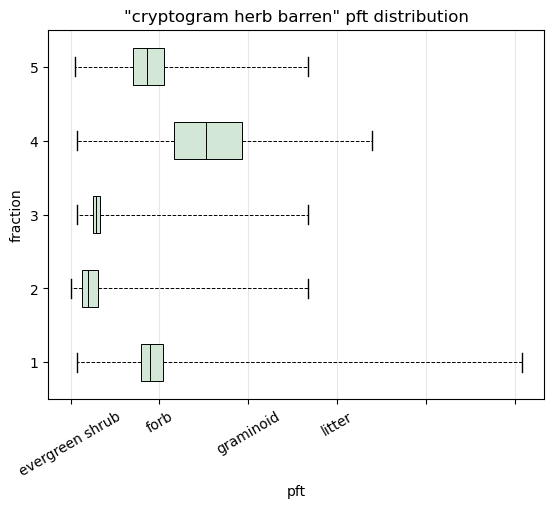

/tmp/ipykernel_68507/4091933650.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)


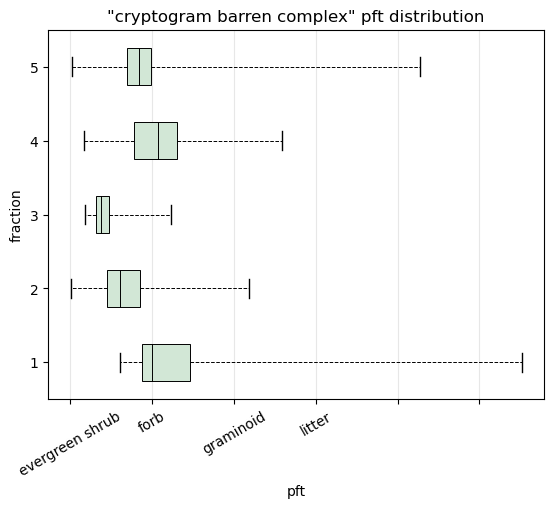

/tmp/ipykernel_68507/4091933650.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)


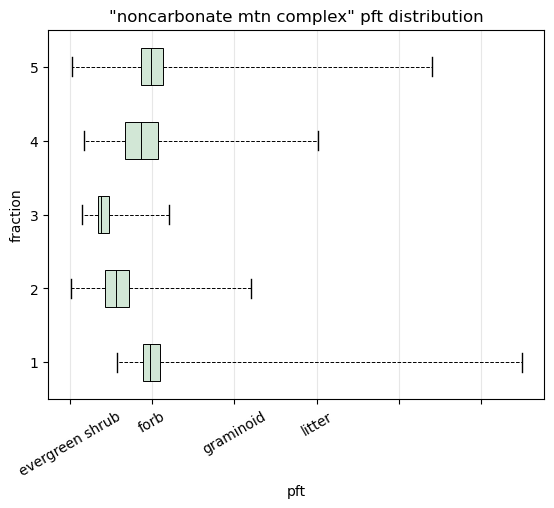

/tmp/ipykernel_68507/4091933650.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)


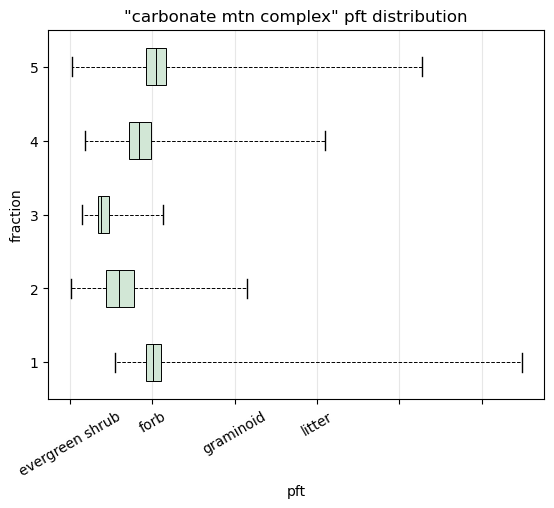

/tmp/ipykernel_68507/4091933650.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)


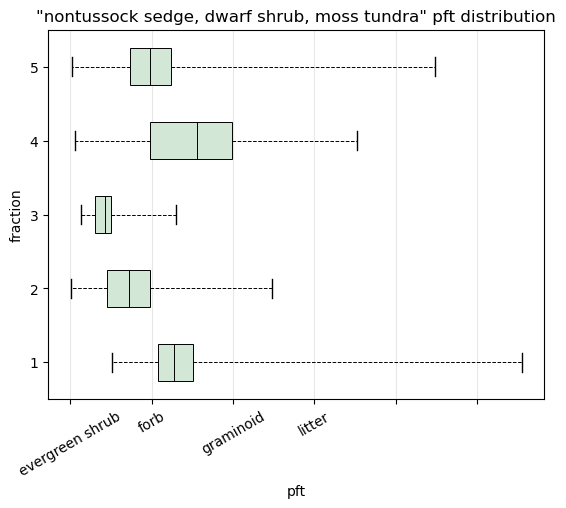

/tmp/ipykernel_68507/4091933650.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)


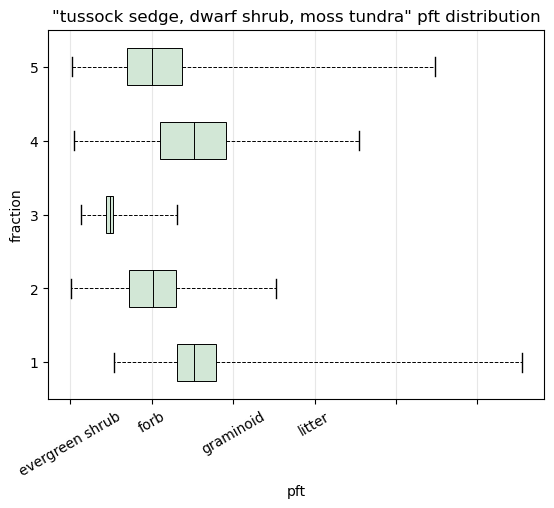

/tmp/ipykernel_68507/4091933650.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)


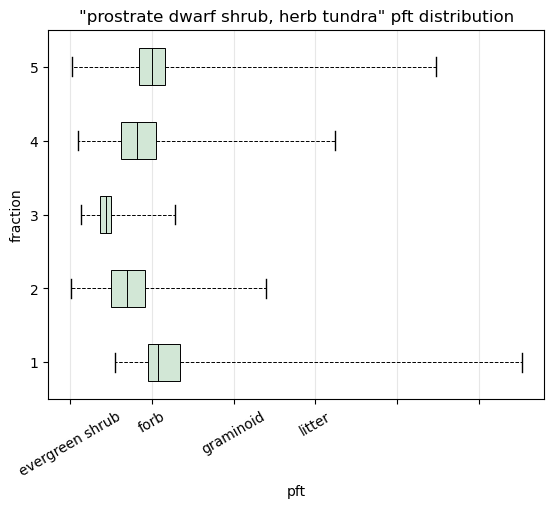

/tmp/ipykernel_68507/4091933650.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)


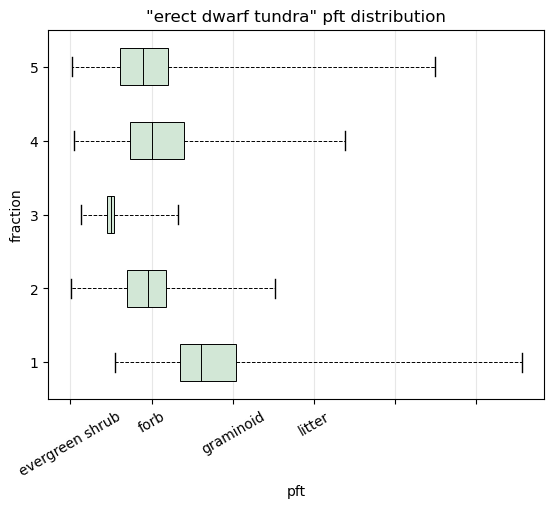

/tmp/ipykernel_68507/4091933650.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)


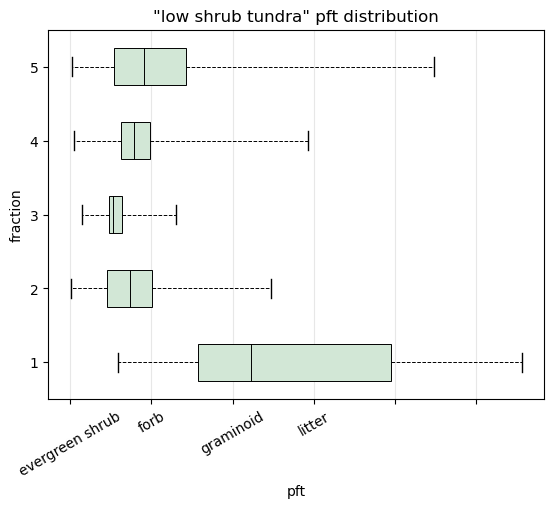

/tmp/ipykernel_68507/4091933650.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)


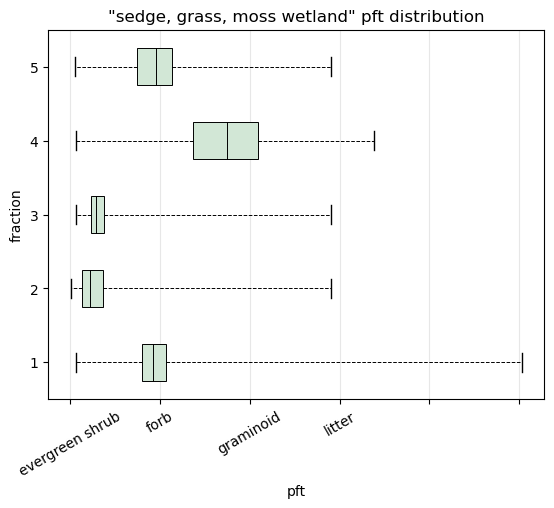

/tmp/ipykernel_68507/4091933650.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)


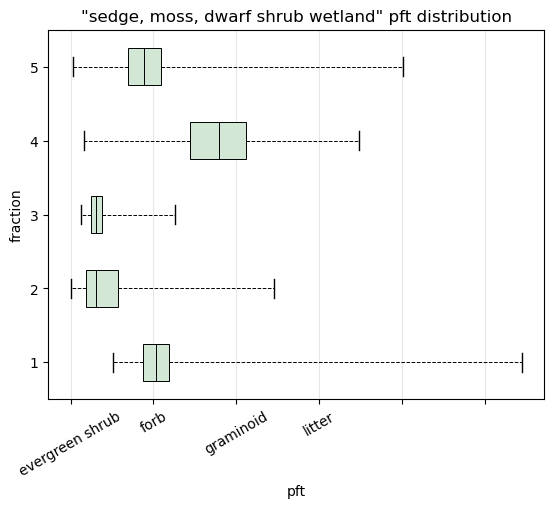

/tmp/ipykernel_68507/4091933650.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)


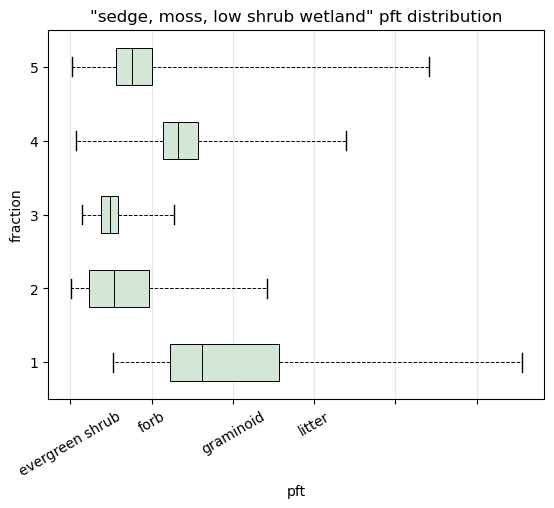

/tmp/ipykernel_68507/4091933650.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)


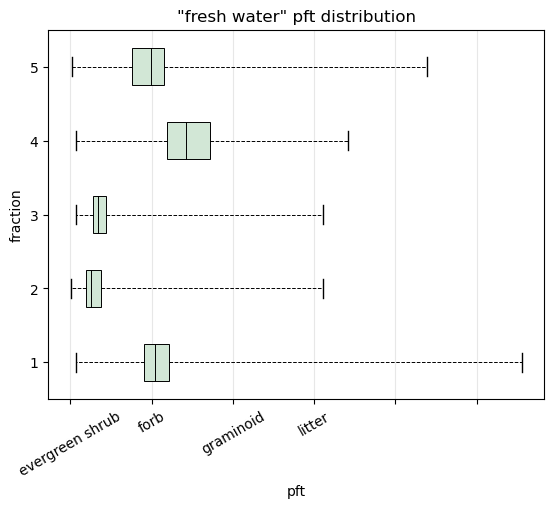

/tmp/ipykernel_68507/4091933650.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)


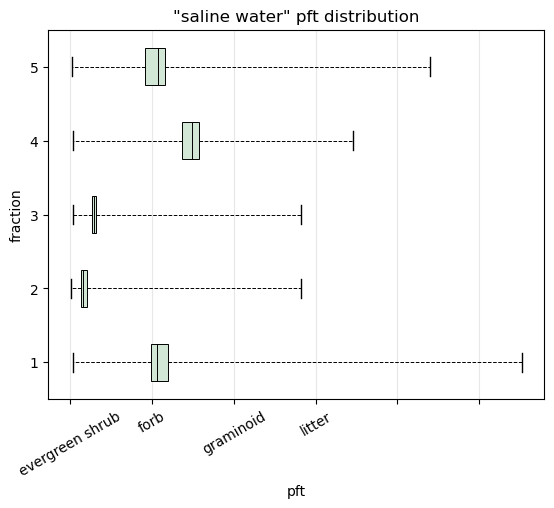

/tmp/ipykernel_68507/4091933650.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)


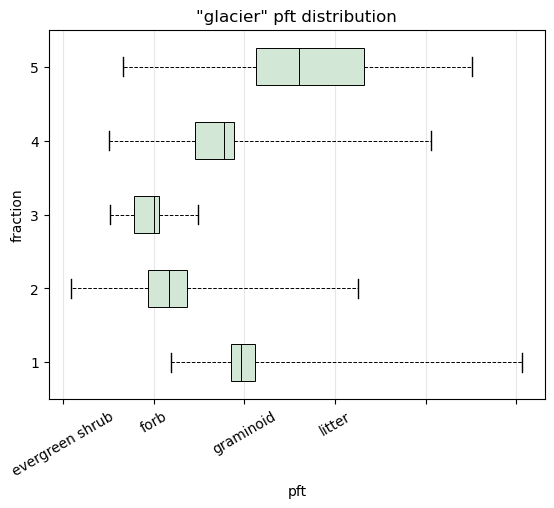

/tmp/ipykernel_68507/4091933650.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabs)


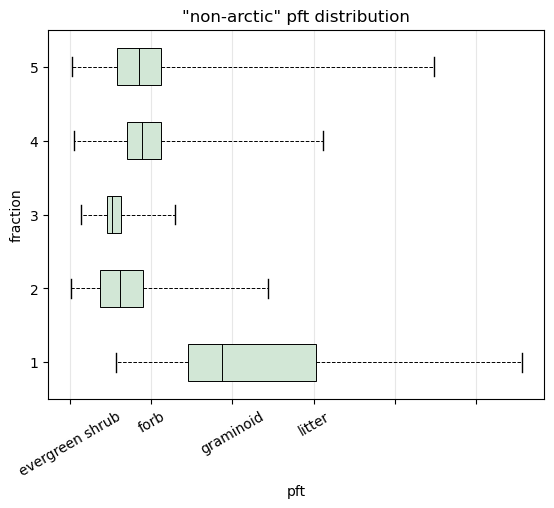

In [105]:
all_stats = pd.concat(pft_dfs, axis=0)
grouped = all_stats.groupby('zone')
for name, group in grouped:
    
    stats = []
    xlabs = []
    
    for index, row in group.iterrows():

        med = row['median']
        q1 = row['first_quart']
        q3 = row['third_quart']
        whislo = row['min']
        whishi = row['max']
        pft = row['pft']
        zone = row['zone']

        pft_dict = {'med': med, 'q1': q1, 'q3': q3, 'whislo': whislo, 'whishi': whishi}
        stats.append(pft_dict)
        
        for classif in cavm_labs:
            if zone in classif:
                zone_lab = classif[1]
                
        xlabs.append(pft)

    _, ax = plt.subplots();
    ax.bxp(stats, showfliers=False, vert=False, patch_artist=True,
           whiskerprops=dict(linestyle='--',linewidth=0.7, color='black'),
           boxprops=dict(linewidth=0.7, facecolor='#d2e7d6'),
           medianprops=dict(linewidth=0.7, color='black'))
    
    ax.set_xticklabels(xlabs)
    plt.grid(axis='x', alpha=.3)
    plt.ylabel('fraction')
    plt.xlabel('pft')
    plt.xticks(rotation=30)
    plt.title(f'"{zone_lab}" pft distribution')
    plt.show()